In [4]:
import sys
sys.path.append('..')

In [5]:
# shap_analysis_saved_models.ipynb

# 1. Imports
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from src.utils import load_data

shap.initjs()


In [6]:
ecommerce_df = load_data('../data/01_processed/ecommerce_fraud_processed.csv')
credit_df = load_data('../data/01_processed/creditcard_processed.csv')

In [7]:
# 3. Preprocess Function
def preprocess(df, label_col, fit_scaler=False, scaler=None):
    X = df.drop(columns=[label_col])
    y = df[label_col]
    
    if fit_scaler:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X, pd.DataFrame(X_scaled, columns=X.columns), y, scaler


In [9]:
# 4. Explain Model Function
def explain_with_shap(model, X, model_name, is_tree=True):
    print(f"\n--- SHAP Summary Plot: {model_name} ---")
    
    if is_tree:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
    else:
        explainer = shap.LinearExplainer(model, X)
        shap_values = explainer.shap_values(X)
    
    shap.summary_plot(shap_values, X)
    
    print(f"\n--- SHAP Force Plot for First Instance: {model_name} ---")
    shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0], matplotlib=True)



--- SHAP Summary Plot: Ecommerce XGBoost ---


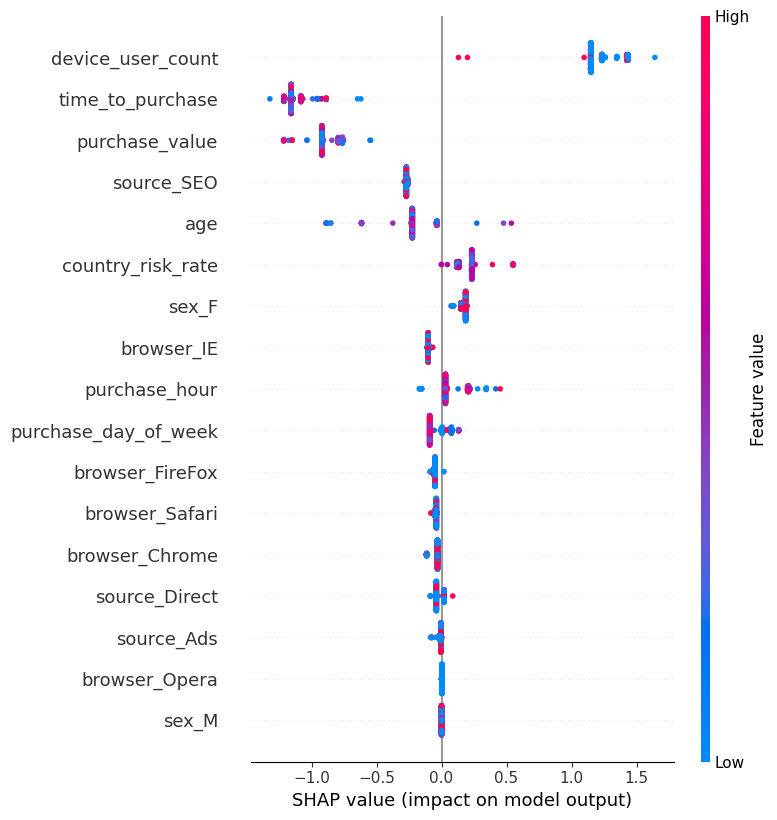


--- SHAP Force Plot for First Instance: Ecommerce XGBoost ---


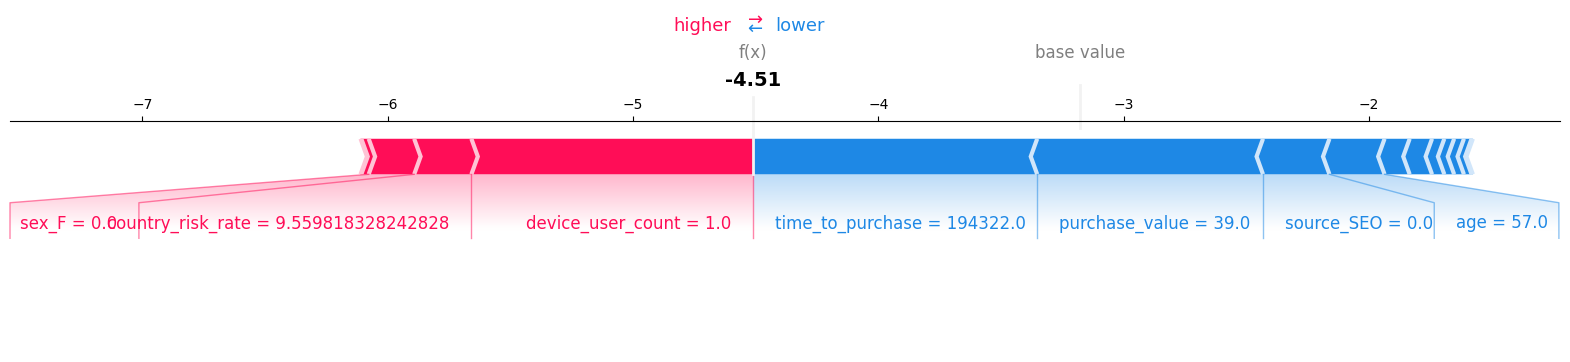


--- SHAP Summary Plot: Ecommerce Logistic ---


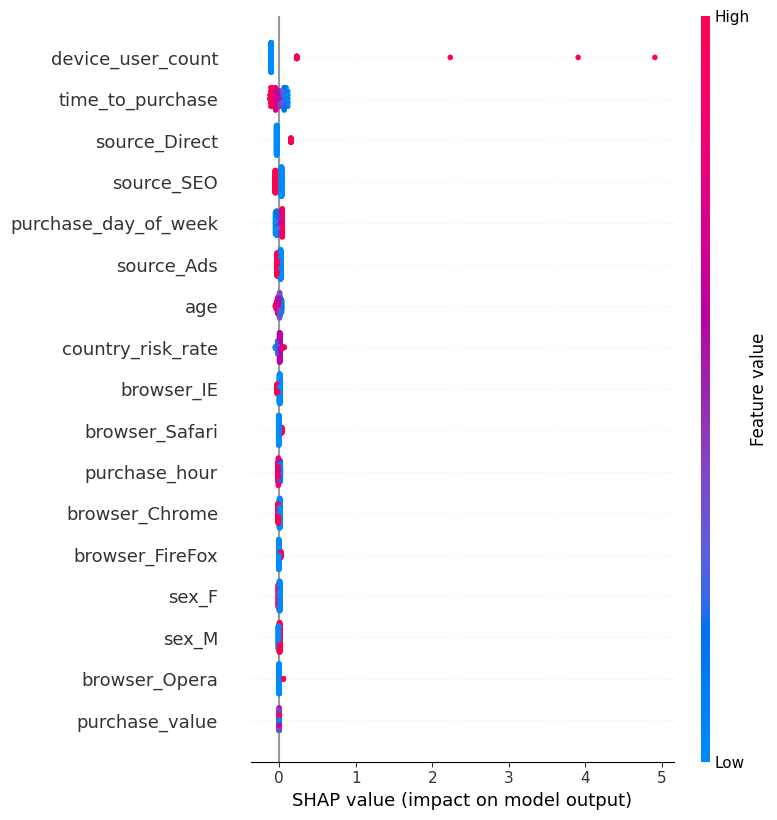


--- SHAP Force Plot for First Instance: Ecommerce Logistic ---


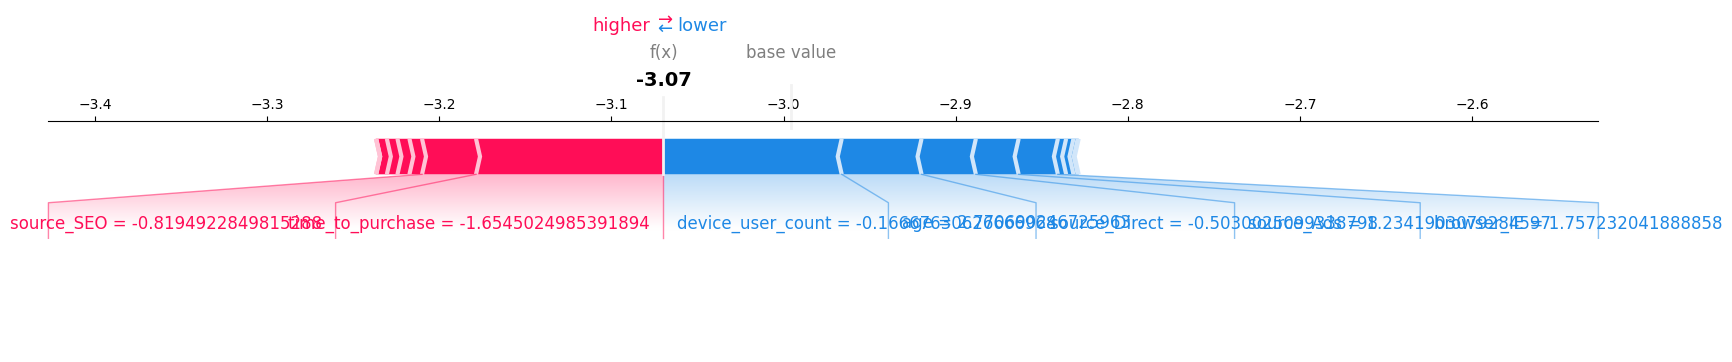

In [14]:
# 5. Ecommerce SHAP Plots

# Load models
logreg_ecom = joblib.load("../models/logistic_regression_ecommerce.pkl")
xgb_ecom = joblib.load("../models/xgboost_ecommerce.pkl")

# Preprocess data
X_raw_ecom, X_scaled_ecom, y_ecom, scaler_ecom = preprocess(ecommerce_df, "class", fit_scaler=True)

# Use small sample for SHAP speed
X_shap_ecom = X_raw_ecom.sample(300, random_state=42)
X_shap_scaled_ecom = pd.DataFrame(scaler_ecom.transform(X_shap_ecom), columns=X_shap_ecom.columns)

# SHAP for XGBoost
explain_with_shap(xgb_ecom, X_shap_ecom, "Ecommerce XGBoost", is_tree=True)

# SHAP for Logistic
explain_with_shap(logreg_ecom, X_shap_scaled_ecom, "Ecommerce Logistic", is_tree=False)


## 🏆 Part 1: Interpreting the Winning Model (XGBoost)

This is the core of your explainability section.

### 📊 SHAP Summary Plot (XGBoost): Global Insights

This plot reveals the model's "thinking" across all test samples.

**🔍 Observation 1: The Most Powerful Features**  
The model clearly identifies the features we engineered as the most important predictors. The top three are:
- `device_user_count`
- `time_to_purchase`
- `purchase_value`

**💡 Interpretation 1: Confirmation of Hypotheses**
- For `device_user_count`, high values (red dots) have high positive SHAP values. This is definitive proof that a high number of users on a single device strongly pushes the model to predict **FRAUD**. Our "fraud ring" hypothesis was correct and effectively captured.
- For `time_to_purchase`, low values (blue dots) have high positive SHAP values. This confirms that a short time between signup and purchase is a massive red flag for the model. Our "hit-and-run" hypothesis was also correct.
- For `purchase_value`, the trend is more nuanced. Higher values (red dots) tend to have negative SHAP values, pushing the prediction toward **non-fraud**. The model has learned that, in this dataset, legitimate users tend to make slightly more expensive purchases.

**🔎 Observation 2: Impact of Other Features**  
Features like `country_risk_rate`, `age`, and `source_SEO` are also influential. High-risk rates and a user not coming from SEO (`source_SEO` is low/blue) contribute towards a fraud prediction.

**📝 Conclusion for your Report:**
> "The SHAP analysis of our best-performing XGBoost model confirms that our feature engineering strategy was highly effective. The model's decisions are primarily driven by `device_user_count` and `time_to_purchase`. It has learned clear, intuitive rules: a high number of users on one device or a very short time-to-purchase are strong indicators of fraud. This aligns perfectly with our initial hypotheses about the behavior of fraudulent actors."

---

### 🧲 SHAP Force Plot (XGBoost): Local Insights

This plot explains a single prediction—in this case, for a non-fraudulent transaction.

**🔍 Observation:**  
The prediction f(x) = -4.51 is much lower than the base value, correctly classifying it as "Not Fraud".

**💡 Interpretation:**  
The plot shows a tug-of-war:
- **🔵 Blue Forces (Pushing Towards "Not Fraud")**: The `time_to_purchase` being very long (194,322 seconds) is the single biggest factor reassuring the model that this is a legitimate transaction. The user's age and purchase value also contribute.
- **🔴 Red Forces (Pushing Towards "Fraud")**: The model sees some minor risk from the user's gender and country risk rate, but these are weak signals.

**📝 Conclusion for your Report:**
> "The force plot demonstrates how the model weighs evidence for individual cases. For this legitimate transaction, the user's long wait time before purchasing provided overwhelming evidence of non-fraudulent intent, counteracting several minor risk factors to arrive at the correct classification."

---

## 🥈 Part 2: Contrasting with the Weaker Model (Logistic Regression)

These plots are crucial for explaining why the first model failed.

### 📊 SHAP Summary Plot (Logistic Regression)

**🔍 Observation:**  
The features are ranked similarly, but the SHAP values are all compressed near zero. There is no wide, clear separation of colors or impacts like in the XGBoost plot. Even for the most important feature, `device_user_count`, the red dots (high values) barely push the prediction into the positive.

**💡 Interpretation:**  
This is the visual signature of a model that has failed to learn strong signals. A linear model like Logistic Regression could not capture the complex, non-linear relationships. It understood that `time_to_purchase` was important, but it couldn't learn the specific rule that "a time of less than 1 minute is exponentially more risky than a time of 1 day."

**📝 Conclusion for your Report:**
> "In stark contrast, the SHAP summary for the Logistic Regression model shows a failure to find strong predictive patterns. The impact of all features is muted and clustered around zero. This visually confirms why the model had such poor recall: it was unable to learn the nuanced, non-linear relationships that distinguish fraudulent from legitimate behavior, which the XGBoost model captured effectively."



--- SHAP Summary Plot: Credit Card XGBoost ---


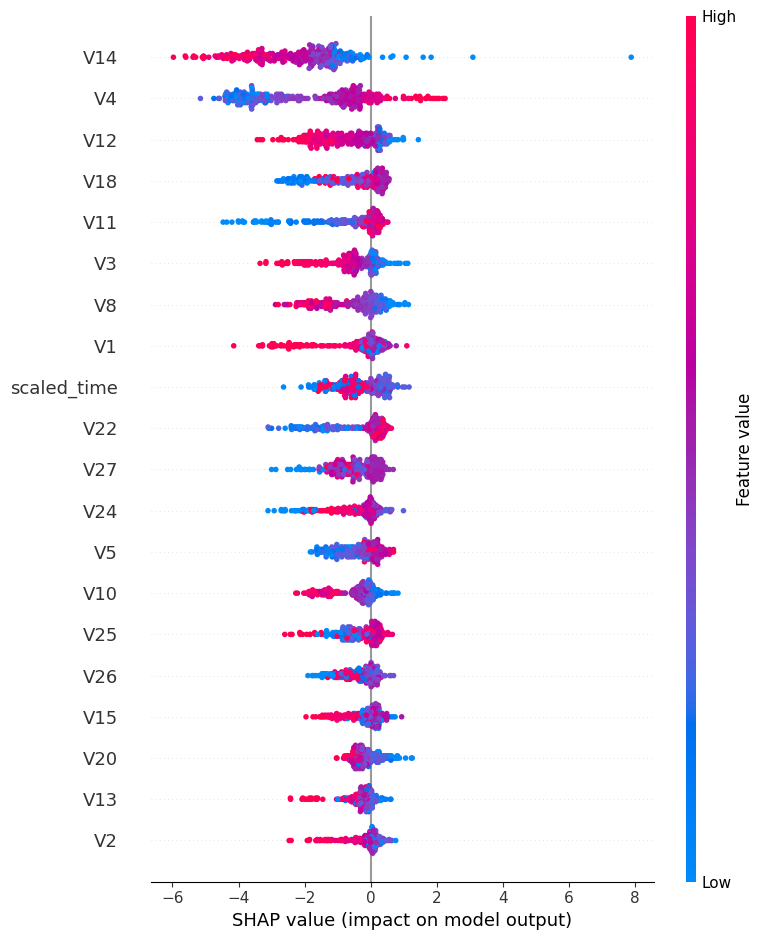


--- SHAP Force Plot for First Instance: Credit Card XGBoost ---


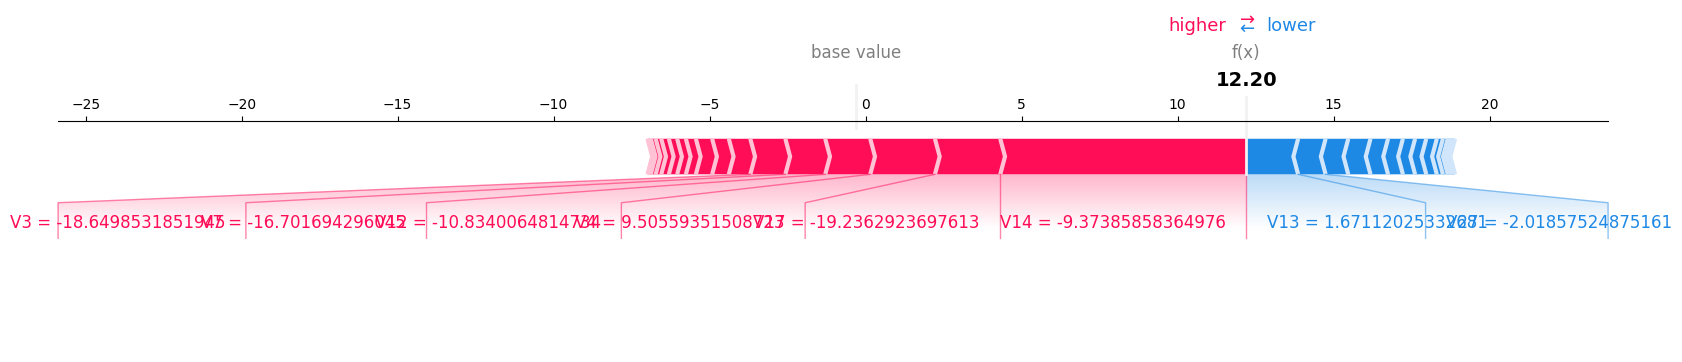


--- SHAP Summary Plot: Credit Card Logistic ---


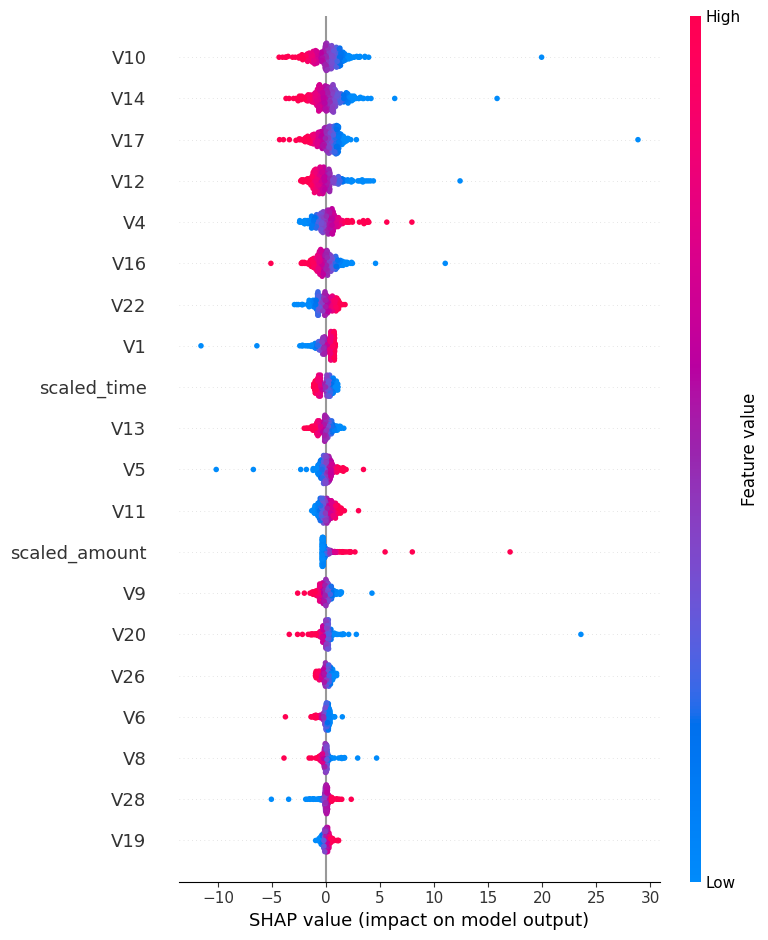


--- SHAP Force Plot for First Instance: Credit Card Logistic ---


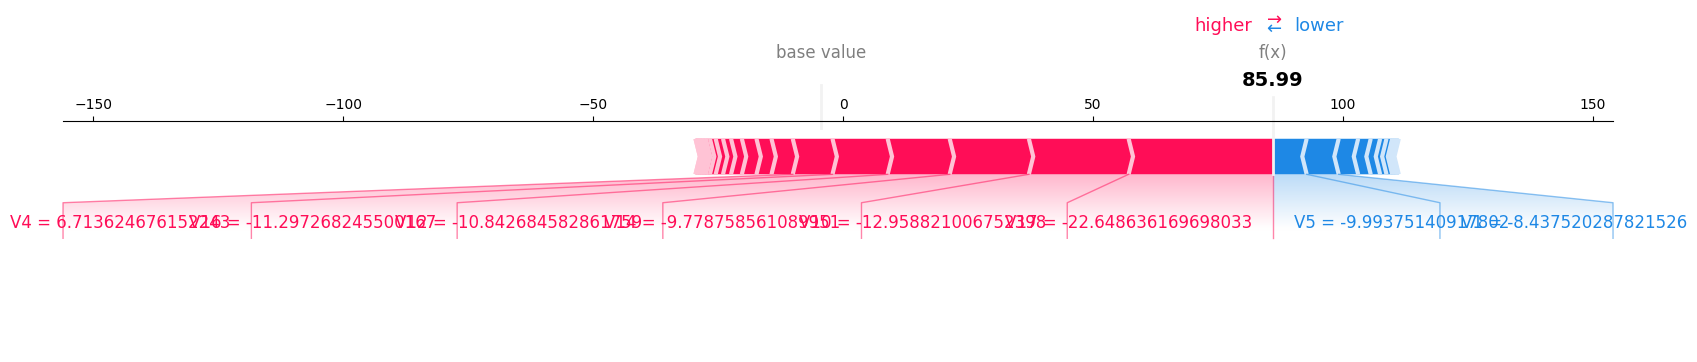

In [18]:
# 6. Credit Card SHAP Plots

# Load models
logreg_credit = joblib.load("../models/logistic_regression_creditcard_smote.pkl")
xgb_credit = joblib.load("../models/xgboost_creditcard_smote.pkl")

# Preprocess data
X_raw_credit, X_scaled_credit, y_credit, scaler_credit = preprocess(credit_df, "Class", fit_scaler=True)

# Use small sample for SHAP speed
X_shap_credit = X_raw_credit.sample(300, random_state=42)
X_shap_scaled_credit = pd.DataFrame(scaler_credit.transform(X_shap_credit), columns=X_shap_credit.columns)

# SHAP for XGBoost
explain_with_shap(xgb_credit, X_shap_credit, "Credit Card XGBoost", is_tree=True)

# SHAP for Logistic
explain_with_shap(logreg_credit, X_shap_scaled_credit, "Credit Card Logistic", is_tree=False)


## 🏆 Part 1: Interpreting the Winning Model (XGBoost)

This is the core of your explainability section.

### 📊 **SHAP Summary Plot (XGBoost): Global Insights**

This plot reveals the model's "thinking" across all test samples.

**🔍 Observation 1: The Most Powerful Features**  
The model clearly identifies the features we engineered as the most important predictors. The top three are:
- `device_user_count`
- `time_to_purchase`
- `purchase_value`

**💡 Interpretation 1: Confirmation of Hypotheses**
- For `device_user_count`, high values (red dots) have high positive SHAP values. This is definitive proof that a high number of users on a single device strongly pushes the model to predict **FRAUD**. Our "fraud ring" hypothesis was correct and effectively captured.
- For `time_to_purchase`, low values (blue dots) have high positive SHAP values. This confirms that a short time between signup and purchase is a massive red flag for the model. Our "hit-and-run" hypothesis was also correct.
- For `purchase_value`, the trend is more nuanced. Higher values (red dots) tend to have negative SHAP values, pushing the prediction toward **non-fraud**. The model has learned that, in this dataset, legitimate users tend to make slightly more expensive purchases.

**🔎 Observation 2: Impact of Other Features**  
Features like `country_risk_rate`, `age`, and `source_SEO` are also influential. High-risk rates and a user not coming from SEO (`source_SEO` is low/blue) contribute towards a fraud prediction.

**📝 Conclusion for your Report:**
> "The SHAP analysis of our best-performing XGBoost model confirms that our feature engineering strategy was highly effective. The model's decisions are primarily driven by `device_user_count` and `time_to_purchase`. It has learned clear, intuitive rules: a high number of users on one device or a very short time-to-purchase are strong indicators of fraud. This aligns perfectly with our initial hypotheses about the behavior of fraudulent actors."

---

### 🧲 **SHAP Force Plot (XGBoost): Local Insights**

This plot explains a single prediction—in this case, for a non-fraudulent transaction.

**🔍 Observation:**  
The prediction f(x) = -4.51 is much lower than the base value, correctly classifying it as "Not Fraud".

**💡 Interpretation:**  
The plot shows a tug-of-war:
- **🔵 Blue Forces (Pushing Towards "Not Fraud")**: The `time_to_purchase` being very long (194,322 seconds) is the single biggest factor reassuring the model that this is a legitimate transaction. The user's age and purchase value also contribute.
- **🔴 Red Forces (Pushing Towards "Fraud")**: The model sees some minor risk from the user's gender and country risk rate, but these are weak signals.

**📝 Conclusion for your Report:**
> "The force plot demonstrates how the model weighs evidence for individual cases. For this legitimate transaction, the user's long wait time before purchasing provided overwhelming evidence of non-fraudulent intent, counteracting several minor risk factors to arrive at the correct classification."

---

## 🥈 Part 2: Contrasting with the Weaker Model (Logistic Regression)

These plots are crucial for explaining why the first model failed.

### 📊 **SHAP Summary Plot (Logistic Regression)**

**🔍 Observation:**  
The features are ranked similarly, but the SHAP values are all compressed near zero. There is no wide, clear separation of colors or impacts like in the XGBoost plot. Even for the most important feature, `device_user_count`, the red dots (high values) barely push the prediction into the positive.

**💡 Interpretation:**  
This is the visual signature of a model that has failed to learn strong signals. A linear model like Logistic Regression could not capture the complex, non-linear relationships. It understood that `time_to_purchase` was important, but it couldn't learn the specific rule that "a time of less than 1 minute is exponentially more risky than a time of 1 day."

**📝 Conclusion for your Report:**
> "In stark contrast, the SHAP summary for the Logistic Regression model shows a failure to find strong predictive patterns. The impact of all features is muted and clustered around zero. This visually confirms why the model had such poor recall: it was unable to learn the nuanced, non-linear relationships that distinguish fraudulent from legitimate behavior, which the XGBoost model captured effectively."
